# Activation stats

In [1]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *


In [2]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

/Users/carles/mambaforge/envs/miniai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

# Baseline

In [5]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1, 8, ks=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        nn.Flatten()]

In [6]:
from torcheval.metrics import MulticlassAccuracy

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [60]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.160,2.300,0,train
0.199,2.130,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

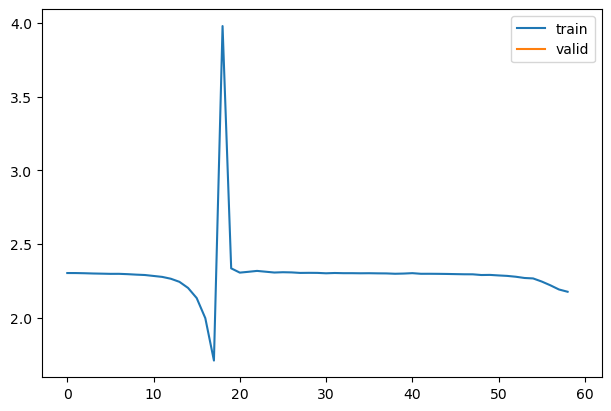

In [10]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

# Hooks

## Manual insertion

In [32]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
    
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x
    
    def __iter__(self):
        return iter(self.layers)

accuracy,loss,epoch,train
0.160,2.300,0,train
0.199,2.130,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

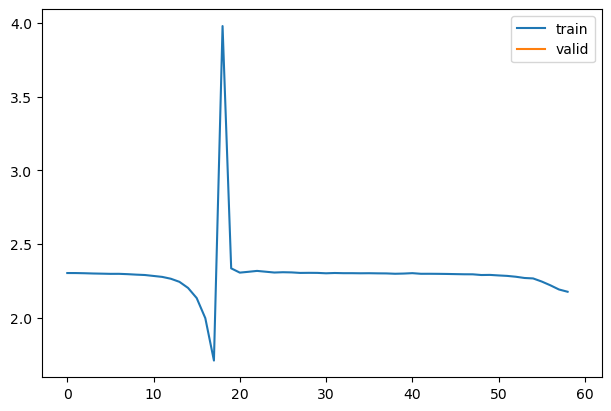

In [33]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

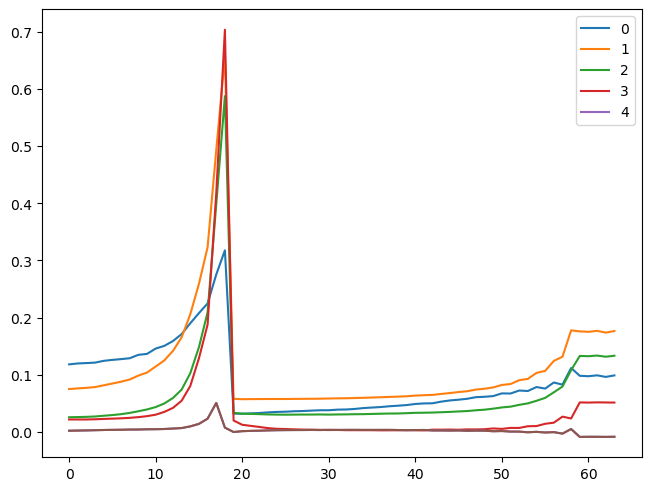

In [18]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

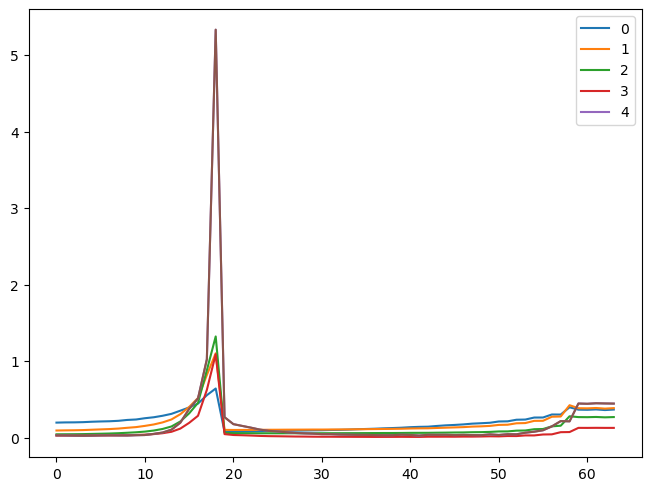

In [19]:
for l in model.act_stds:
    plt.plot(l)
plt.legend(range(5))

# Pytorch Hooks

In [20]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [21]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [22]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

In [23]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.160,2.300,0,train
0.199,2.130,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

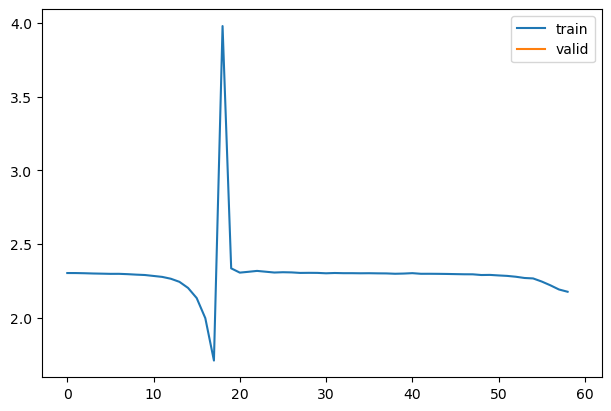

In [24]:
fit(model)

# Hook class

In [35]:
class Hook():
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [44]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [37]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.160,2.300,0,train
0.199,2.130,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

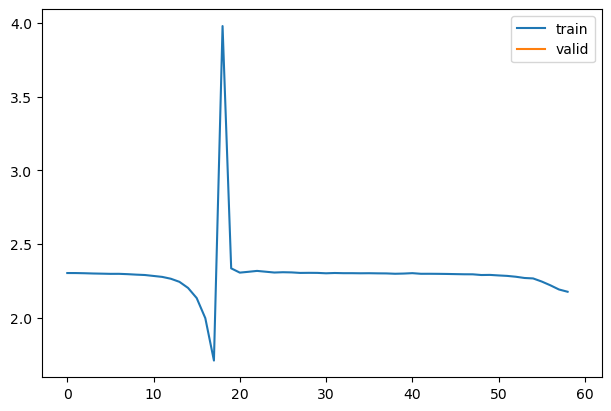

In [38]:
learn = fit(model)

# Hooks class

In [45]:
class Hooks(list):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.remove()
    def __del__(self):
        self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self:
            h.remove()

In [46]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.160,2.300,0,train
0.199,2.130,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

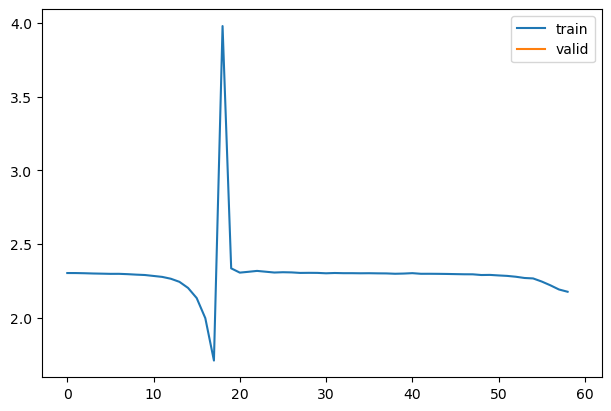

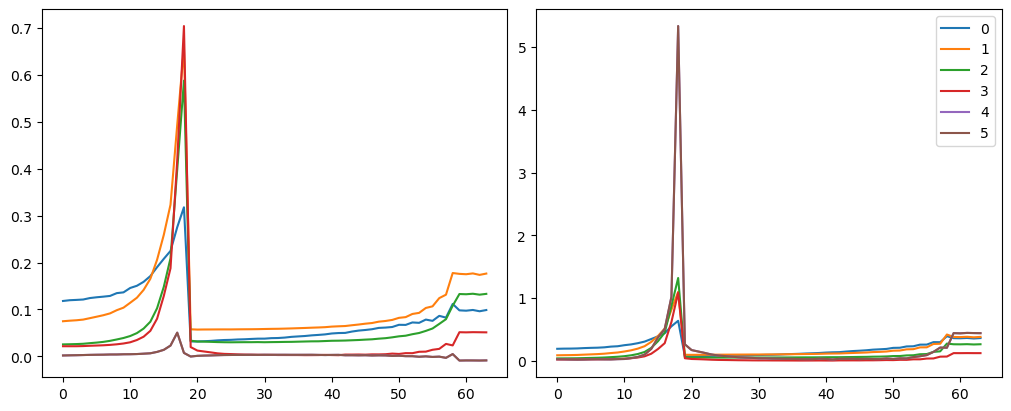

In [47]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        for i in 0,1:
            axs[i].plot(h.stats[i])
    plt.legend(range(6))

# Histogram

In [48]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

In [50]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.160,2.300,0,train
0.199,2.130,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

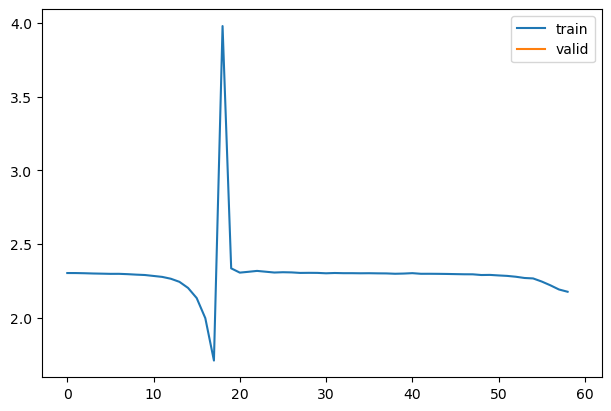

In [51]:
with Hooks(model, append_stats) as hooks:
    fit(model)

In [52]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

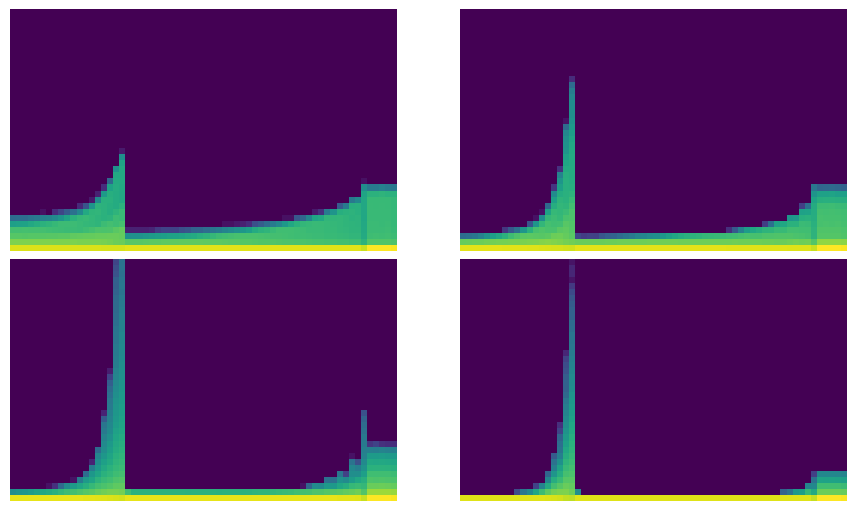

In [54]:
fig, axes = subplots(2,2, figsize=(9,5))
for ax, h in zip(axes.flatten(), hooks[:4]):
    show_image(get_hist(h), ax, origin='lower')

In [55]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

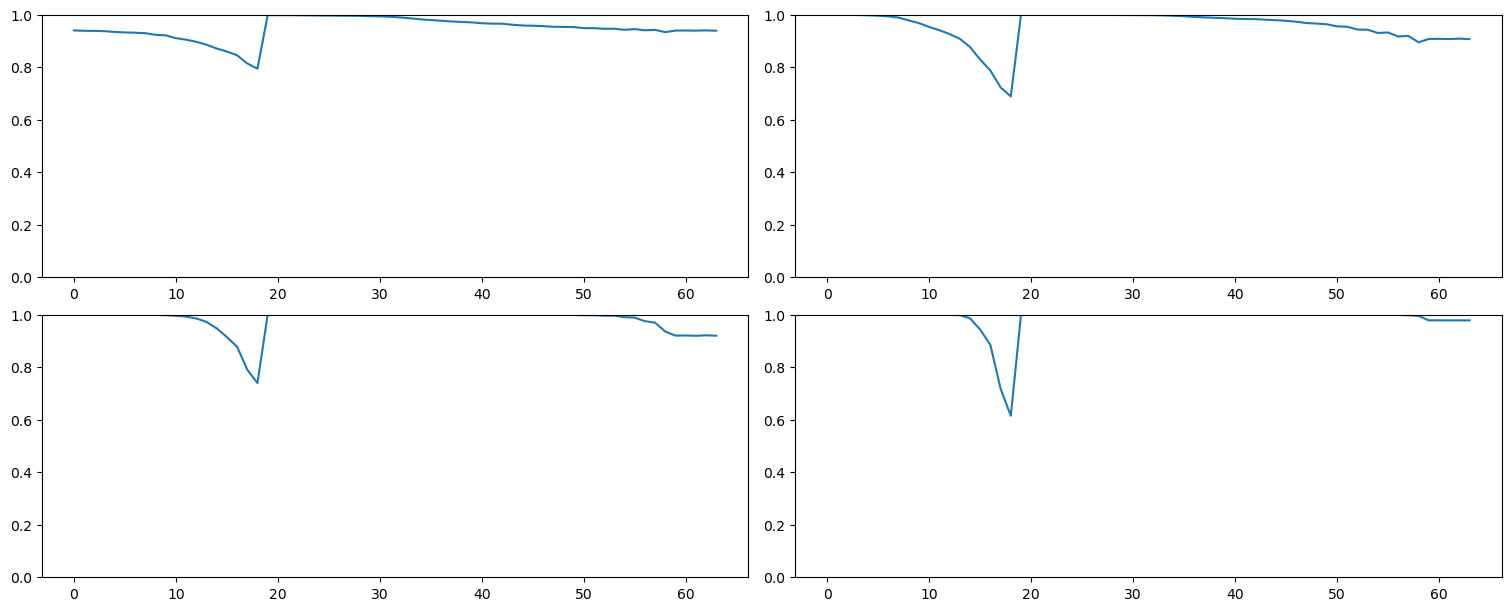

In [56]:
fig, axes = subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

# HooksCallback

In [57]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self):
        mods = fc.filter_ex(self.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, self._hookfunc)
    
    def _hookfunc(self, *args, **kwargs):
        if self.training:
            self.hookfunc(*args, **kwargs)
    
    def after_fit(self):
        self.hooks.remove()
    
    def __iter__(self):
        return iter(self.hooks)
    
    def __len__(self):
        return len(self.hooks)

In [58]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

In [61]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/carles/mambaforge/envs/miniai/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/xp/fkqy9xb90zx086tyvm0871f80000gn/T/ipykernel_6241/1851451710.py", line 3, in <module>
    fit(model, xtra_cbs=[hc])
  File "/var/folders/xp/fkqy9xb90zx086tyvm0871f80000gn/T/ipykernel_6241/3882170809.py", line 3, in fit
    learn.fit(epochs)
  File "/Users/carles/Documents/for_fun/mini-diffusers/miniai/learner.py", line 198, in fit
  File "/Users/carles/Documents/for_fun/mini-diffusers/miniai/learner.py", line 143, in _f
    def after_epoch(self, learn):
                ^^^^^^^^^^^^^^^^^^
  File "/Users/carles/Documents/for_fun/mini-diffusers/miniai/learner.py", line 208, in callback
    if self.opt_func:
  File "/Users/carles/Documents/for_fun/mini-diffusers/miniai/learner.py", line 33, in run_cbs
    raise AttributeError(name)
        ^^^^^^^^^^^